In [2]:
from keras.models import Model, load_model, Sequential
from keras.layers import Input, LSTM, Dense, RepeatVector, \
                         TimeDistributed, Activation
    
from helpers import *
import importlib
from importlib import reload
from scipy.stats import hmean

# ignore some Keras warnings regarding deprecations and model saving 
import warnings
warnings.filterwarnings('ignore')

Sentences from the [tatoeba dataset](https://tatoeba.org/eng/downloads)

In [3]:
batch_size = 128  # Batch size for training.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples =40000 # Number of samples to train on.
# Path to the datatxt file on disk.
data_path = 'sentences.txt'

epochs = 150 # Number of epochs to train for.


In [4]:
# Hand-pick maximum sequence lengths
max_seq_length = 30

In [5]:
def load_preprocessed(data_path, max_len):
    """Dirty helper fn loading a file from disk, doing some basic preprocessing
        and filtering out phrases that are longer than our maximum sequence length"""
    with open(data_path) as f:
        lines = f.readlines()
    lines = text_preprocess(lines)
    # allow only for a limited count of 
    allowed_chars = set(' !"#$%&\'()+,-./0123456789:;?[]_`abcdefghijklmnopqrstuvwxyz{}')
    selected = []
    for l in lines:
        if all([c in allowed_chars for c in l.strip()]) and \
           len(l) <= max_len:
            selected.append(l)
    # suffle deterministically
    Random(0).shuffle(selected)
    return selected

In [22]:
all_phrases = load_preprocessed(data_path, max_seq_length)
train_phrases = all_phrases[:num_samples]
test_phrases = all_phrases[num_samples:num_samples + 1000]
print('All phrases in dataset: ', len(all_phrases))
print('Training phrases: ', len(train_phrases))
print('Test phrases: ', len(test_phrases))

print("\n * ".join(['Examples:'] + all_phrases[:10]))

All phrases in dataset:  400082
Training phrases:  40000
Test phrases:  1000
Examples:
 * tom looked like a rich man
 * i don't see why this is news
 * tom will figure it out
 * tom went on talking
 * i didn't ask for your opinions
 * only tom can answer that
 * please, do not get excited
 * he is extremely unbiased
 * what's stopping you?
 * don't make me leave


In [8]:
# create doken indices out of all phrases
token_idx = token_index(all_phrases + ['\t', '\n'])
# ^^ \t and \n are our [START] and [END] delimiters. With this trick
# we are adding them to the token index

num_encoder_tokens = len(token_idx)

print('Number of unique tokens:', num_encoder_tokens)

Number of unique tokens: 57


In [24]:
def simple_lstm(output_len, token_count):
    """Generate the model"""
    initializer = 'he_normal'
    model = Sequential()
    # "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE
    # note: in a situation where your input sequences have a variable length,
    # use input_shape=(None, nb_feature).
    encoder = LSTM(latent_dim, input_shape=(None, token_count), 
                   kernel_initializer=initializer)
    model.add(encoder)

    # For the decoder's input, we repeat the encoded input for each time step
    model.add(RepeatVector(output_len))
    # The decoder RNN could be multiple layers stacked or a single layer

    decoder = LSTM(latent_dim, return_sequences=True, kernel_initializer=initializer)
    model.add(decoder)

    # For each of step of the output sequence, decide which character should be chosen
    model.add(TimeDistributed(Dense(token_count, kernel_initializer=initializer)))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [25]:
# adds \t and \n delimiters at the begining and end of each phrase
wrapped_train_phrases =  wrap_with_delims(train_phrases)
wrapped_train_phrases[:3]

['\ttom looked like a rich man\n',
 "\ti don't see why this is news\n",
 '\ttom will figure it out\n']

In [26]:
max_target_seq_length = max_seq_length + 2 # accomodate for the delimiters

In [27]:
model = simple_lstm(max_target_seq_length, len(token_idx))

In [28]:
X = vectorize_batch(train_phrases, token_idx, max_seq_length, dtype=np.bool)
Y = vectorize_batch(wrapped_train_phrases, token_idx, max_target_seq_length, dtype=np.bool)

Train on 36800 samples, validate on 3200 samples
Epoch 1/100
36800/36800 [==============================] - 52s 1ms/step - loss: 1.8198 - acc: 0.2628 - val_loss: 1.7032 - val_acc: 0.2863
Epoch 2/100
36800/36800 [==============================] - 52s 1ms/step - loss: 1.6217 - acc: 0.3028 - val_loss: 1.5203 - val_acc: 0.3236
Epoch 3/100
36800/36800 [==============================] - 52s 1ms/step - loss: 1.4562 - acc: 0.3377 - val_loss: 1.3772 - val_acc: 0.3542
Epoch 4/100
36800/36800 [==============================] - 52s 1ms/step - loss: 1.3237 - acc: 0.3690 - val_loss: 1.2542 - val_acc: 0.3878
Epoch 5/100
36800/36800 [==============================] - 52s 1ms/step - loss: 1.2067 - acc: 0.3987 - val_loss: 1.1529 - val_acc: 0.4114
Epoch 6/100
36800/36800 [==============================] - 52s 1ms/step - loss: 1.1114 - acc: 0.4242 - val_loss: 1.0551 - val_acc: 0.4408
Epoch 7/100
36800/36800 [==============================] - 52s 1ms/step - loss: 1.0238 - acc: 0.4494 - val_loss: 0.9779 - v

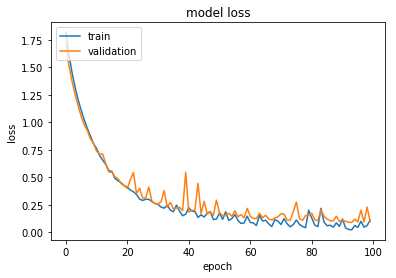

In [31]:
history = model.fit(X,Y, batch_size=batch_size, epochs=100, validation_split=.08)


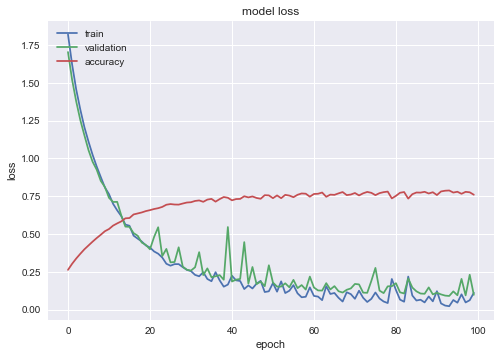

In [44]:
plot_history(history)

In [46]:
def translator_fn(model, token_index, max_seq_len):
    inverse_token_index = {v: k for k, v in token_index.items()}
    def predict(in_phrase):
        x = vectorize_phrase(in_phrase, token_index, max_seq_len)
        pred_idxes = model.predict_classes(x, verbose=0)[0]
        txt = ''.join([inverse_token_index[i] for i in pred_idxes])
        end_idx = txt.find("\n")
        return txt[1:end_idx]
    return predict

Create a function that will represent our trained identity fn

In [71]:
rearned_fn = translator_fn(model, token_idx, max_seq_length)

In [72]:
# let's see what our model has learned so far
# by trying to "correct" some correct phrases
for p in  train_phrases[:10]:
    print(p, '->',rearned_fn(p))

tom looked like a rich man -> tom looked like a rich man
i don't see why this is news -> i don't see why this is news
tom will figure it out -> tom will figure it out
tom went on talking -> tom went on talking
i didn't ask for your opinions -> i didn't ask for your opinions
only tom can answer that -> only tom can answer that
please, do not get excited -> please, do not get excited
he is extremely unbiased -> he is extremely unbaased
what's stopping you? -> what's stopping you?
don't make me leave -> don't make me leave


In [73]:
for p in  test_phrases[:10]:
    print(p, '->',rearned_fn(p))

tom is hypocritical -> tom is mopocritical
nobody else can know -> nobody else can know
we'll do the same -> we'll do the same
i'm not asking tom -> i'm not asking tom
i got off the elevator -> i got off the elevator
tom is on duty now -> tom is on duty now
it's cause for major concern -> it's cause fom mamo  concenn
would you like some more rice? -> would you like some more fice?
i was very sad when mary died -> i was very sas when mary didd
they're all waiting -> they're all waiting


In [74]:
def evaluate(texts, rearned_fn):
    errors = 0.0
    for t in texts:
        if t != rearned_fn(t): errors += 1
    return errors / len(texts)

In [75]:
evaluate(train_phrases[:1000], rearned_fn)

0.187

In [76]:
evaluate(test_phrases[:1000], rearned_fn)

0.394